In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('STB.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
df

,Price
0,11750
1,12550
2,12900
3,13300
4,13000
...,...
1237,27000
1238,27400
1239,27000
1240,27200


In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=10736.587, Time=0.74 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11188.107, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=11005.067, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=10732.853, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=10732.974, Time=0.73 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=10732.923, Time=0.36 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=10734.656, Time=0.88 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.340 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val = model.predict(n_periods=len(y_val))

In [8]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[29018.59999559 29137.19999118 29255.79998676 29374.39998235
 29492.99997794 29611.59997353 29730.19996911 29848.7999647
 29967.39996029 30085.99995588 30204.59995147 30323.19994705
 30441.79994264 30560.39993823 30678.99993382 30797.59992941
 30916.19992499 31034.79992058 31153.39991617 31271.99991176
 31390.59990734 31509.19990293 31627.79989852 31746.39989411
 31864.9998897  31983.59988528 32102.19988087 32220.79987646
 32339.39987205 32457.99986764]


In [9]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 12551.924211115482
Testing RMSE: 29287.89818955229
Validation MAPE: 51.15176688343561
Testing MAPE: 106.27639718676987
Validation MAE: 12239.399722034226
Testing MAE: 24407.823910687846


Validation RMSE: 12551.924211115482
Testing RMSE: 29287.89818955229


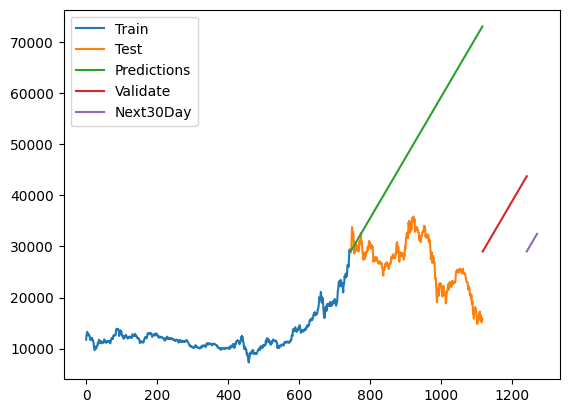

In [10]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()